### Predict Property type based on feature set (ML Model)
### London property classifier 

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:
# 1. Load UK Land Registry data
# source: https://www.kaggle.com/datasets/jakewright/house-price-data
csv_path = 'data/kaggle_london_house_price_data.csv'
df =pd.read_csv(csv_path)

print('shape:', df.shape)
df.head()

shape: (418201, 28)


,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


### Explore data and clean

In [3]:
print(df.describe())
print(df.columns)

            latitude      longitude      bathrooms       bedrooms  \
count  418201.000000  418201.000000  340270.000000  377665.000000   
mean       51.507522      -0.101426       1.444265       2.474884   
std         0.056171       0.086930       0.724478       1.160506   
min        51.385708      -0.347055       1.000000       1.000000   
25%        51.464315      -0.155996       1.000000       2.000000   
50%        51.501581      -0.108482       1.000000       2.000000   
75%        51.548515      -0.043582       2.000000       3.000000   
max        51.665823       0.139249       9.000000       9.000000   

        floorAreaSqM    livingRooms  rentEstimate_lowerPrice  \
count  392991.000000  357701.000000            416460.000000   
mean       98.926543       1.282275              3299.054171   
std        55.938911       0.574412              3168.625404   
min        10.000000       1.000000               300.000000   
25%        63.000000       1.000000              1800.0000

In [4]:
# notes on features:
# df.propertyType
# property type is an important categorical feature, but need to convert to correct type first
# rooms = bedrooms + livingrooms
# it makes mmore sense to combine these two features into one 'rooms' feature

In [5]:
### convert to correct types
df['history_date'] = pd.to_datetime(df['history_date'])
df['history_price'] = df['history_price'].astype(float)

# remove 'bad' data
df = df.dropna(subset=['history_price','history_date'])
df = df.sort_values(by=['history_date'])
print('shape after basic cleaning:', df.shape)

shape after basic cleaning: (418201, 28)


In [6]:
# filter out outliers, 2_000_000 GBP seems reasonable for London housing market
min_price= 50_000
max_price = 2_000_000

df = df[df['history_price'] <= max_price]
df = df[df['history_price'] >= min_price]

print('shape after filtering for outliers:', df.shape)

shape after filtering for outliers: (395361, 28)


### Feature enginerring for classification

In [7]:
cols = [
    'history_date',
    'history_price',
    'bedrooms',
    'livingRooms',
    'bathrooms',
    'floorAreaSqM',
    'latitude',
    'longitude',
    'propertyType'
]

# drop rows with missing values in selected columns
df_model=df[cols].copy()
df_model = df_model.dropna().reset_index(drop=True)

# cast to numeric types
numeric_cols = ['bedrooms','livingRooms','bathrooms','floorAreaSqM','latitude','longitude']
for col in numeric_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# feature: total rooms
df_model['rooms'] = df_model['bedrooms'] +  df_model['livingRooms']

# feature: log price
df_model['log_price'] = np.log(df_model['history_price'])

print("df_model shape after cleaning: ", df_model.shape)
df_model.head()


df_model shape after cleaning:  (304040, 11)


,history_date,history_price,bedrooms,livingRooms,bathrooms,floorAreaSqM,latitude,longitude,propertyType,rooms,log_price
0,1995-01-02,830000.0,1.0,1.0,1.0,45.0,51.517282,-0.110314,Purpose Built Flat,2.0,13.629181
1,1995-01-03,249950.0,2.0,1.0,2.0,71.0,51.495505,-0.132379,Flat/Maisonette,3.0,12.429016
2,1995-01-03,133000.0,4.0,2.0,1.0,137.0,51.588774,-0.139599,End Terrace House,6.0,11.798104
3,1995-01-03,128500.0,2.0,1.0,1.0,97.0,51.466089,0.006967,Mid Terrace House,3.0,11.763684
4,1995-01-03,75000.0,3.0,2.0,1.0,135.0,51.451327,-0.007569,Terrace Property,5.0,11.225243


In [8]:
# create numerical labels for propertyType
df_model['properType_cat'] = df_model['propertyType'].astype('category')
df_model['properType_label'] = df_model['properType_cat'].cat.codes

class_names = list(df_model['properType_cat'].cat.categories)
num_classes = len(class_names)
print("Property types: ", class_names)
print("Number of property types: ", num_classes)

# features for classification
feature_cols_cls = [
    'rooms',
    'bathrooms',
    'floorAreaSqM',
    'latitude',
    'longitude',
    'log_price'
]

# make sure they are all numeric
for col in feature_cols_cls:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_cls= df_model.dropna(subset=feature_cols_cls + ['properType_label']).reset_index(drop=True)
X_cls = df_cls[feature_cols_cls].values.astype(np.float32)
y_cls = df_cls['properType_label'].values.astype(np.int64)

print("X_xls shape: ", X_cls.shape)
print("y_cls shape: ", y_cls.shape)

Property types:  ['Bungalow Property', 'Converted Flat', 'Detached Bungalow', 'Detached House', 'Detached Property', 'End Terrace Bungalow', 'End Terrace House', 'End Terrace Property', 'Flat/Maisonette', 'Mid Terrace Bungalow', 'Mid Terrace House', 'Mid Terrace Property', 'Purpose Built Flat', 'Semi-Detached Bungalow', 'Semi-Detached House', 'Semi-Detached Property', 'Terrace Property', 'Terraced', 'Terraced Bungalow']
Number of property types:  19
X_xls shape:  (304040, 6)
y_cls shape:  (304040,)


## Train-test split and scaling

In [9]:
# use a stratified train-test split due to proportional class representation
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cls,
    y_cls,
    test_size=0.3,
    random_state=SEED,
    stratify=y_cls
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Test set shape: ", X_test.shape)

# scale features accordingly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set shape:  (212828, 6)
Validation set shape:  (45606, 6)
Test set shape:  (45606, 6)


In [10]:
# dataset class and dataloaders
class PropertyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
batch_size = 64
train_dataset = PropertyDataset(X_train_scaled, y_train)
val_dataset = PropertyDataset(X_val_scaled, y_val)
test_dataset = PropertyDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of training batches: ", len(train_loader))
print("Number of validation batches: ", len(val_loader))
print("Number of test batches: ", len(test_loader))

Number of training batches:  3326
Number of validation batches:  713
Number of test batches:  713


### Build MLP classifier

In [11]:
class ProperyTypeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes),
        )

    def forward(self, x):
        return self.net(x)
    
input_dim = X_train_scaled.shape[1]
model = ProperyTypeClassifier(input_dim=input_dim, hidden_dim=128, num_classes=num_classes).to(device)
print(model)

ProperyTypeClassifier(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=19, bias=True)
  )
)


### loss, optimiser and triaing functions

In [12]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, criterion, optimiser, epoch):
    
    model.train()
    total_loss = 0.0
    n_batches = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimiser.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimiser.step()

        total_loss += loss.item()
        n_batches += 1
    avg_loss = total_loss / n_batches
    print(f"Epoch {epoch}: Train Loss: {avg_loss:.4f}")
    return avg_loss    

In [16]:
def evaluate(model,loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    n_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            n_batches += 1

            preds = outputs.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += y_batch.size(0)
    
    avg_loss = total_loss /max(n_batches,1)
    accuracy = 100.0 * total_correct / max(total_samples,1)

    return avg_loss, accuracy


In [17]:
def train_eval(epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        train_loss = train(model, train_loader, criterion, optimiser, epoch)
        val_loss, val_accuracy = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch}: Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies

### Train and evaluate

In [18]:
EPOCHS = 15
train_losses, val_losses, val_accuracies = train_eval(EPOCHS)

Epoch 1: Train Loss: 1.4297
Epoch 1: Val Loss: 1.3998, Val Accuracy: 47.07%
Epoch 2: Train Loss: 1.4112
Epoch 2: Val Loss: 1.3896, Val Accuracy: 47.59%
Epoch 3: Train Loss: 1.4012
Epoch 3: Val Loss: 1.3823, Val Accuracy: 47.78%
Epoch 4: Train Loss: 1.3944
Epoch 4: Val Loss: 1.3801, Val Accuracy: 47.93%
Epoch 5: Train Loss: 1.3898
Epoch 5: Val Loss: 1.3737, Val Accuracy: 48.27%
Epoch 6: Train Loss: 1.3844
Epoch 6: Val Loss: 1.3679, Val Accuracy: 48.11%
Epoch 7: Train Loss: 1.3813
Epoch 7: Val Loss: 1.3645, Val Accuracy: 48.50%
Epoch 8: Train Loss: 1.3786
Epoch 8: Val Loss: 1.3637, Val Accuracy: 48.41%
Epoch 9: Train Loss: 1.3758
Epoch 9: Val Loss: 1.3596, Val Accuracy: 48.47%
Epoch 10: Train Loss: 1.3738
Epoch 10: Val Loss: 1.3610, Val Accuracy: 48.37%
Epoch 11: Train Loss: 1.3720
Epoch 11: Val Loss: 1.3577, Val Accuracy: 48.72%
Epoch 12: Train Loss: 1.3704
Epoch 12: Val Loss: 1.3547, Val Accuracy: 48.88%
Epoch 13: Train Loss: 1.3688
Epoch 13: Val Loss: 1.3543, Val Accuracy: 48.80%
Epoc

In [19]:
# test evaluation
test_loss, test_accuracy = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.3490, Test Accuracy: 48.93%


### Plot 

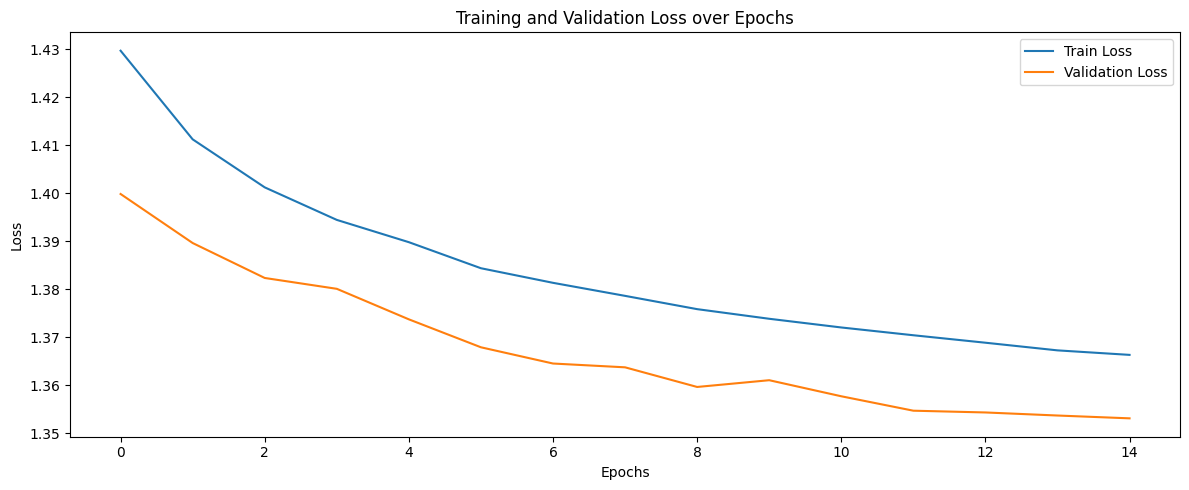

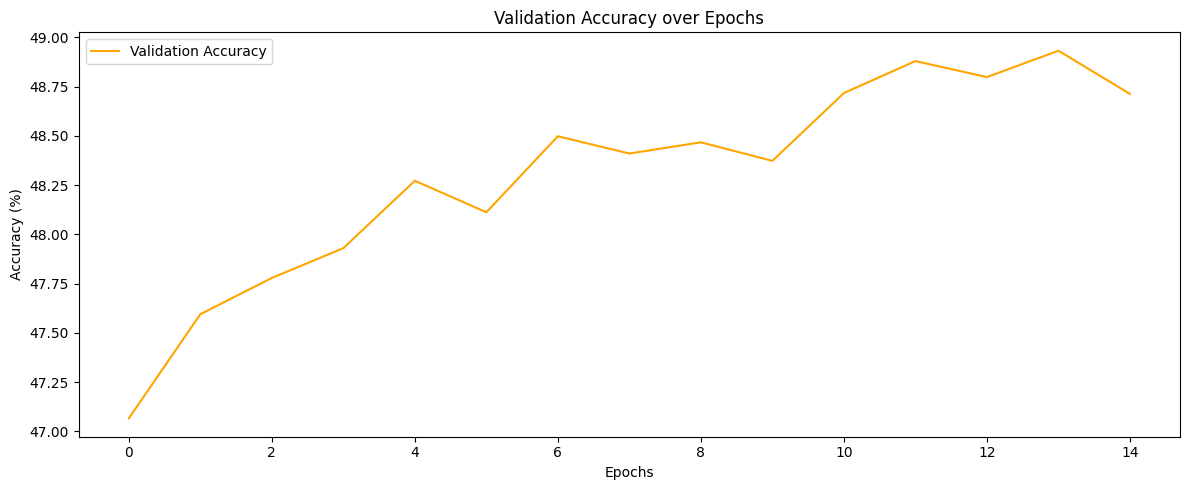

In [20]:
plt.figure(figsize=(12,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()
